# Example commands: ERA5 daily aggregate precipitation data
## EDS 220 HW 1, Fall 2021

The following are a few examples you may find useful when carrying out your analysis of precipitation data! Also feel free to look up examples online, or from the course Github materials.

In [1]:
# Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


### The `ee.Authenticate()` and `ee.Initialize` methods

In our initial experimentations with GEE, we performed our authentication step prior to starting Jupyter Lab. If you forget to do this for some reason, you can use the following alternate steps to authenticate your GEE credentials and initialize the GEE tools. `ee.Authenticate()` will send you to a new window where you can log in with your Google username/password, then enter an authentication code into the Jupyter notebook. After that, `ee.Initialize()` initializes the connection between your machine and the GEE API:

In [ ]:
ee.Authenticate()
ee.Initialize()

### 1) Displaying Metadata

The most straightforward way to display the metadata associated with a GEE dataset is to look at the data description website; but you can also display this information within Python. 

Let's use the ERA5 daily aggregate data we worked with in class as an example. First, we can read in the entire set of ERA5 data as an ImageCollection:

In [43]:
# Add Earth Engine dataset: daily data from ERA5
gdat = ee.ImageCollection('ECMWF/ERA5/DAILY')

"['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dewpoint_2m_temperature', 'total_precipitation', 'surface_pressure', 'mean_sea_level_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m']"

But this is not terribly helpful, since GEE won't let us view the metadata for an image collection in the same way as one might wish for. To see what I mean, try to issue the `getInfo()` method on the gdat object above:

`gdat.getInfo()`

...you will see that it crashes with an error message about aborting after 5000 elements, since there is a lot of data in this image collection.

Instead, what we can do is pull an arbitrary image from the collection to see what's in there - we can safely assume that the metadata for the other images will be similar since it's all from the same data source.

The `.first()` method is useful here, since it just pulls the first image in the collection. You could get similar results by filtering/averaging over a given time period as well - the goal is just to extract something that GEE thinks of as an Image.

In [38]:
testimg=gdat.first()

The `testimg` image is now something that we can query. Let's try something simple: displaying a list of the data contained in the image (GEE refers to these as "bands", which are literally spectral bands for satellite data, but when we're working with a reanalysis like ERA5, this will be the different climate variables produced by the model.)

The commands you need are slightly annoying (in my opinion), since one must first extract a `List` object containing the names of the bands, then apply the `getInfo` method to that list to simply display those names. But using the following should give you a list of variable names that are things like temperature, precipitation, pressure, and wind:

In [40]:
bands=testimg.bandNames()
str(bands.getInfo())

"['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dewpoint_2m_temperature', 'total_precipitation', 'surface_pressure', 'mean_sea_level_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m']"

Here is just another example of how you could do the same thing by filtering the image collection over a specific time range in order to condense everything down to an image.

First we take the `gdat` object containing the full set of ERA5 information, and use the `.filter` method to apply the `ee.Filter.date` function which selects a particular time range. The mean is then calculated, giving a single image containing the mean precipitation for that time range:

In [45]:
gdatflt=gdat.filter(ee.Filter.date('2019-12-01', '2019-12-02')).mean();
bnames=gdatflt.bandNames()
str(bnames.getInfo())

"['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dewpoint_2m_temperature', 'total_precipitation', 'surface_pressure', 'mean_sea_level_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m']"

This is not the only metadata command out there, and I encourage you to explore other ways of viewing things! I found the following URLs helpful, as a starting point:

https://developers.google.com/earth-engine/apidocs/ee-imagecollection

https://developers.google.com/earth-engine/guides/image_info

https://samapriya.github.io/gee-py/projects/infometad/


### 2) Creating Time Series

We didn't cover how to create a time series from a GEE image in class, so here is an example that you can apply to your region of interest. The following is adapted from the Python GEE tutorial at:

https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard



Again, we'll start with the ERA5 daily precipitation image collection `gdat` object that was loaded in earlier: now let's extract information near Santa Barbara. The lat and lon of interest are:
- 34.4208° N, 119.6982° W

We can define a "point" object in Google Earth corresponding to Santa Barbara's coordinates, which we will then use to sample the images in ERA5. We'll also need a "scale" factor, which just specifies the distance from the point of interest to be included in the region:

In [57]:
sb_lon = -119.6982
sb_lat = 34.4208
sb_poi = ee.Geometry.Point(sb_lon, sb_lat)
scale = 1000   # scale in m

In [59]:
pr=gdat.select('total_precipitation')
sb_pr_ts = pr.getRegion(sb_poi, scale).getInfo()


The `sb_pr_ts` object should contain a time series of precipitation near Santa Barbara. This is stored as a `list` so we will next convert it to a `data frame` that the Python "pandas" package can read.

More information on pandas data frames can be found here:

https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python

The below code chunk uses the `pd.DataFrame` method to convert the GEE list object to a data frame. You can look at the contents using print:

In [86]:
df = pd.DataFrame(sb_pr_ts)

print(df)

              0          1         2              3                    4
0            id  longitude  latitude           time  total_precipitation
1      19790102 -119.69602  34.41895   284083200000                    0
2      19790103 -119.69602  34.41895   284169600000              0.00015
3      19790104 -119.69602  34.41895   284256000000             0.000327
4      19790105 -119.69602  34.41895   284342400000             0.019212
...         ...        ...       ...            ...                  ...
15161  20200705 -119.69602  34.41895  1593907200000                    0
15162  20200706 -119.69602  34.41895  1593993600000                 -0.0
15163  20200707 -119.69602  34.41895  1594080000000                    0
15164  20200708 -119.69602  34.41895  1594166400000                    0
15165  20200709 -119.69602  34.41895  1594252800000                    0

[15166 rows x 5 columns]


In addition to the precipitation information, the data frame contains an "id" (string of times in yyyy-mm-dd format), longitude and latitude information, and another time variable. 

**This appears to be poorly documented within Google Earth Engine; but many of the GEE datasets have a "time" coordinate with units of milliseconds (ms). I have not verified whether this is true in all cases.**

I will provide two examples of time handling below, either of which should work depending on your dataset. A good sanity check you can try to confirm that your time axis is correct:
- Go to the dataset description page and locate the "dataset availability" information. This should show you the time period covered by the dataset (see example for ERA5 below).
- Check that the beginning and ending points of your time coordinate are the same as the start/end points listed on the description page. If they're different, something isn't quite right!

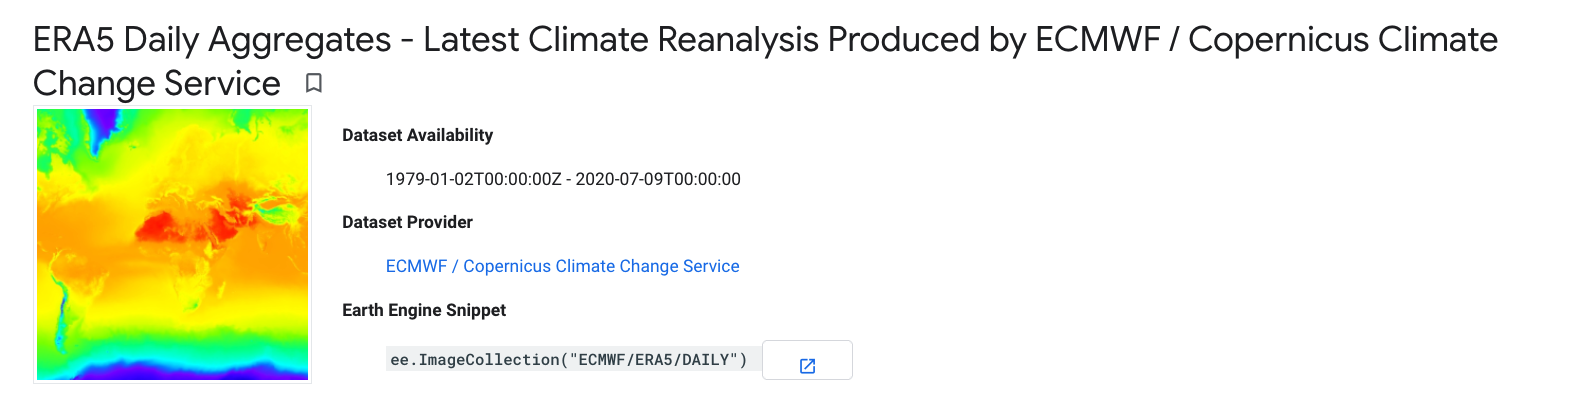

OK we'll come back to the time thing in a minute. First, let's format the data a little bit. The `df` dataframe that gets read in directly from GEE contains the column headers as the first row, rather than as actual header labels. We can change that with the following commands:

In [87]:
headers=df.loc[0]     # Assign the first entry in the data frame to a variable called "headers"
print(headers)        # Look at what's in there

0                     id
1              longitude
2               latitude
3                   time
4    total_precipitation
Name: 0, dtype: object


In [88]:
df = pd.DataFrame(df.values[1:], columns=headers)      # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers
print(df)     # Make sure it worked

0            id  longitude  latitude           time total_precipitation
0      19790102 -119.69602  34.41895   284083200000                   0
1      19790103 -119.69602  34.41895   284169600000             0.00015
2      19790104 -119.69602  34.41895   284256000000            0.000327
3      19790105 -119.69602  34.41895   284342400000            0.019212
4      19790106 -119.69602  34.41895   284428800000            0.007883
...         ...        ...       ...            ...                 ...
15160  20200705 -119.69602  34.41895  1593907200000                   0
15161  20200706 -119.69602  34.41895  1593993600000                -0.0
15162  20200707 -119.69602  34.41895  1594080000000                   0
15163  20200708 -119.69602  34.41895  1594166400000                   0
15164  20200709 -119.69602  34.41895  1594252800000                   0

[15165 rows x 5 columns]


Now that the column names have been appropriately assigned, we can use them to refer to the relevant parts of the data frame. For instance,

`df['time']`

will retrieve the "time" column from the frame.

Let's do that, and then apply a new method to the result: `pd.to_datetime`. This is a function in the pandas package which does exactly what it sounds like: converts a time variable to pandas "datetime" format. You need to tell it what the input time units are, which I've supplied as ms: this makes `pd.to_datetime` assume that time is given in units of ms since the "origin" time, which for Unix machines for some reason is January 1, 1970.

Once you've done this, you can apply the sanity check described above to see if this works for your dataset.

In [90]:
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

Now if we look at the contents of the `df` dataframe, we should get something very much like the previous version, but containing a new column called `datetime` with the formatted date:

In [91]:
df

,id,longitude,latitude,time,total_precipitation,datetime
0,19790102,-119.69602,34.41895,284083200000,0,1979-01-02
1,19790103,-119.69602,34.41895,284169600000,0.00015,1979-01-03
2,19790104,-119.69602,34.41895,284256000000,0.000327,1979-01-04
3,19790105,-119.69602,34.41895,284342400000,0.019212,1979-01-05
4,19790106,-119.69602,34.41895,284428800000,0.007883,1979-01-06
...,...,...,...,...,...,...
15160,20200705,-119.69602,34.41895,1593907200000,0,2020-07-05
15161,20200706,-119.69602,34.41895,1593993600000,-0.0,2020-07-06
15162,20200707,-119.69602,34.41895,1594080000000,0,2020-07-07
15163,20200708,-119.69602,34.41895,1594166400000,0,2020-07-08


If the above does **not** work for your dataset (maybe since the time has a different unit), you can also try this alternate method of date conversion that uses the "id" column. 

Here I'll again use `pd.to_datetime`, this time with the "format" option set: this tells the function the format ofthe input date string (here "year" "month" "day"). 

*note: I also tried this with no format argument and it worked*, Python is pretty smart about interpreting things if your date string is in a fairly standard format. I've just included the format string here so you can see what it looks like. 

Here's another handy website that does a nice job of explaning the various datetime formats:
https://www.dataindependent.com/pandas/pandas-to-datetime/

In [96]:
df['datetime'] = pd.to_datetime(df['id'],format="%Y%m%d")

In [97]:
df

,id,longitude,latitude,time,total_precipitation,datetime
0,19790102,-119.69602,34.41895,284083200000,0,1979-01-02
1,19790103,-119.69602,34.41895,284169600000,0.00015,1979-01-03
2,19790104,-119.69602,34.41895,284256000000,0.000327,1979-01-04
3,19790105,-119.69602,34.41895,284342400000,0.019212,1979-01-05
4,19790106,-119.69602,34.41895,284428800000,0.007883,1979-01-06
...,...,...,...,...,...,...
15160,20200705,-119.69602,34.41895,1593907200000,0,2020-07-05
15161,20200706,-119.69602,34.41895,1593993600000,-0.0,2020-07-06
15162,20200707,-119.69602,34.41895,1594080000000,0,2020-07-07
15163,20200708,-119.69602,34.41895,1594166400000,0,2020-07-08


### 3) Plotting Time Series

Now that we have a time series, let's display it so we can see what it's like. This can be accomplished via the `matplotlib` package, which was loaded in above as `plt`:

(0.0, 0.12)

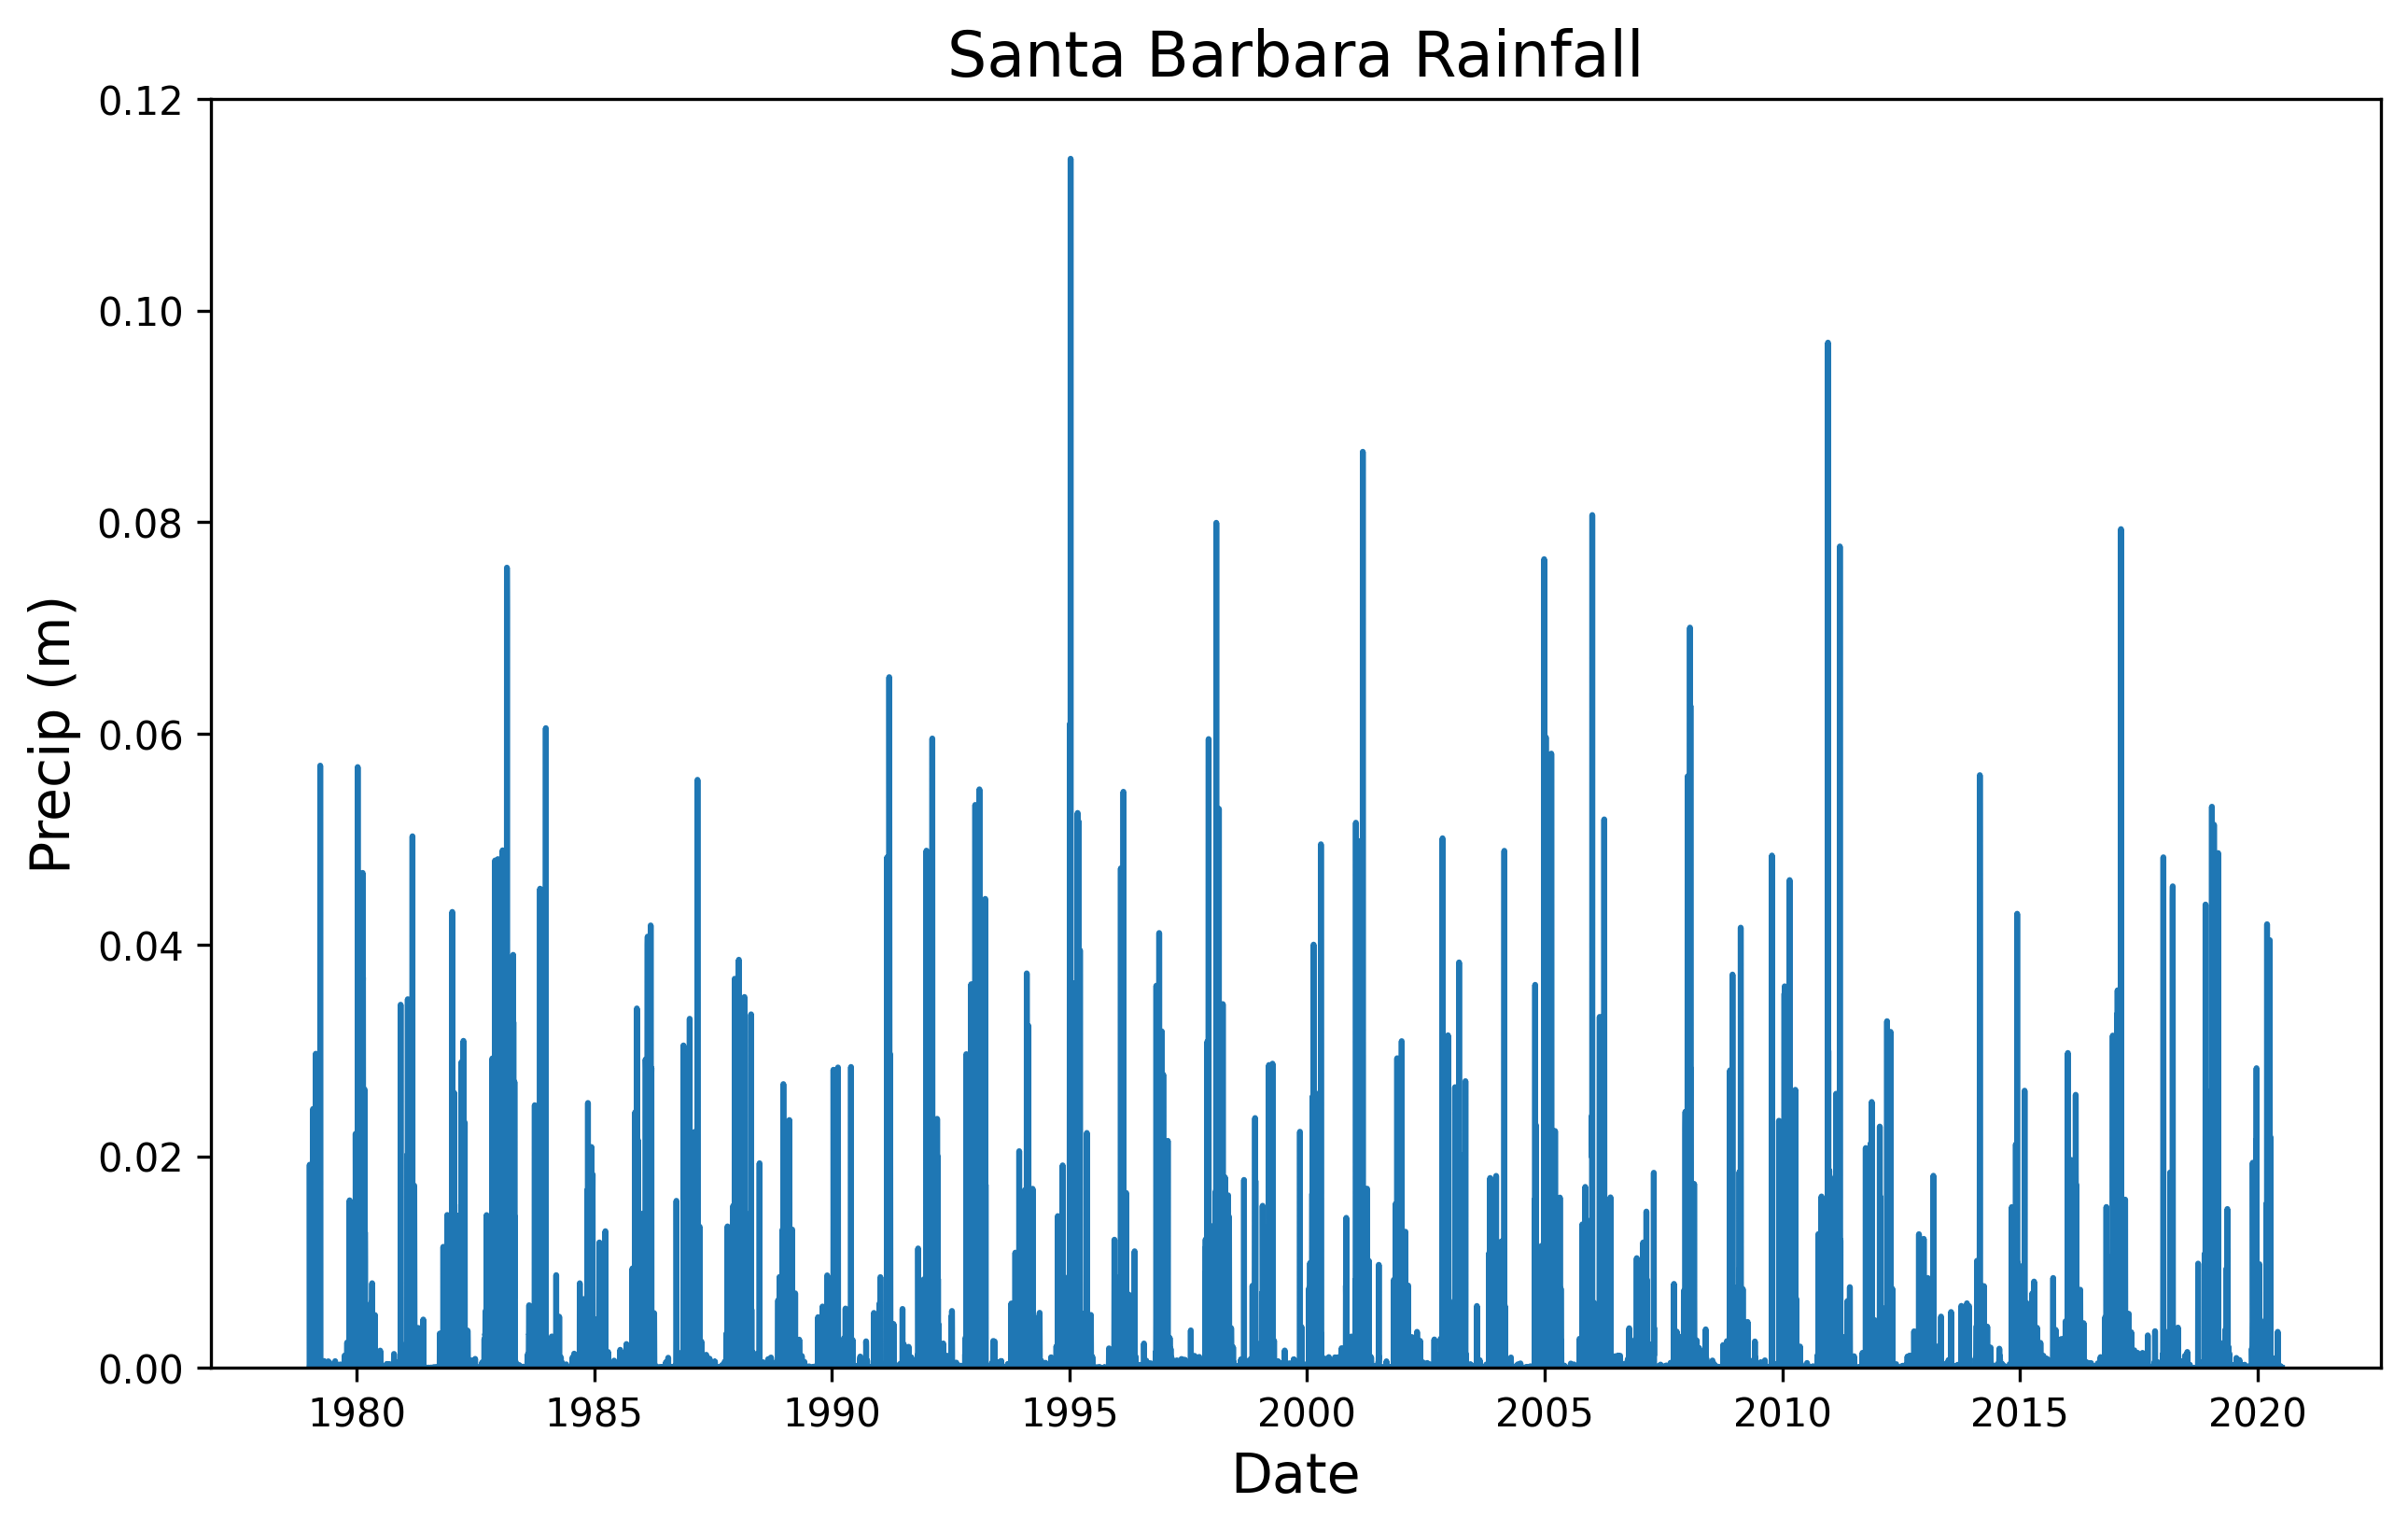

In [110]:
plt.figure(figsize=(10, 6), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(df['datetime'],df['total_precipitation'])   # add data to the plot
plt.title('Santa Barbara Rainfall', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precip (m)', fontsize=14)
plt.ylim(0, 0.12)
